# User Metadata Analysis

This notebook focuses on retrieving, analysing, and visualising **user-level metadata on the English Wikipedia**.  
It covers both the full dataset of **2,336 unique users** and a targeted subset of the **top 10 most active contributors by edit count**, listed below: 
```
Dbachamnn
Irpen
Seryo93
TheDraperyFalls
LSHG
Toddy1
Yulia Romero
Mzajac
UP9
Aleksandr Grigoryev
```

The objective is to understand how **user attributes, roles, and status within Wikipedia** relate to editing behaviour observed in the contributions analysis.

User metadata is retrieved using the **Wikimedia API**, via the `action=query` endpoint with `list=users`, and the following parameters ```ucprop=blockinfo|groups|editcount|registration|emailable|gender```.

---

## Retrieved Parameters and Their Meaning

- **`blockinfo`**  
  Information about whether a user is currently blocked or has been blocked in the past.  
  This provides insight into **sanctioning, moderation, and disciplinary history**.

- **`groups`**  
  Lists the user groups the account belongs to (e.g. `sysop`, `editor`, `bot`).  
  Group membership reflects **institutional authority and access to advanced editorial tools**.

- **`editcount`**  
  Total number of edits made by the user.  
  This is used as a proxy for **experience, seniority, and embeddedness** within Wikipedia.

- **`registration`**  
  The account creation date.  
  This allows estimation of **account age**, which is strongly correlated with trust and editorial legitimacy.

- **`emailable`**  
  Indicates whether the user can be contacted via Wikipedia’s internal email system.  
  This feature is often associated with **established and trusted accounts**.

- **`gender`**  
  Self-declared gender (optional and frequently missing).  
  While used cautiously, it may reveal **structural biases or asymmetries** in participation.

---

## Scope of the Notebook

This notebook contains:

- Reusable functions to retrieve user metadata from Wikipedia
- Exploratory visualisations to identify patterns across user types and experience levels
- Analyses linking user metadata to observed editing behaviour

---

## Research Objective

The final goal of this notebook is to **identify user-level features that correlate with or enable weaponising behaviours** on Wikipedia.  
These features are intended to be:
- empirically grounded,
- interpretable,
- and reusable for the development of a downstream **Large Language Model (LLM)** aimed at analysing, contextualising, or detecting coordinated or manipulative editorial activity.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from datetime import timedelta
from scipy.stats import variation
from tqdm import tqdm

In [28]:
# import our small preprocessed database
df = pd.read_csv('../../datas/final/small_db_preprocess.csv')

In [6]:
# Users list
top10_users = df["user"].value_counts().head(10).index.tolist()
users_list = df['user'].unique().tolist()
df_ip = df[df['user_type'] == 'Anonymous (IP)']
top10_ip_users = df_ip["user"].value_counts().head(10).index.tolist()

# Top 10 users metadata
df_top10_metadata = pd.read_csv('../../datas/interim/All Users Analysis/top10_user_profiles.csv')
df_all_user_metadata = pd.read_csv('../../datas/interim/All Users Analysis/total_user_profiles.csv')

In [52]:
# after cleaning, we merge the metadata dataframe to the database

df_all_user_metadata=df_all_user_metadata.dropna(axis='index', how='any', subset=['registration'])
df_all_user_metadata = df_all_user_metadata.rename(columns={"name": "user"})
df_enriched = df.merge(
    df_all_user_metadata,
    on="user",
    how="left"
)

In [53]:
df_enriched.head(5)

,article,user,date,comment,llm_output,weaponised,year,user_type,userid,editcount,...,blockedby,blockedbyid,blockreason,blockedtimestamp,blockexpiry,blocknocreate,blockowntalk,blockedtimestampformatted,blockemail,blockpartial
0,COVID-19 pandemic in Ukraine,Agathoclea,2020-03-11T20:56:06Z,removed [[Category:2019–20 coronavirus outbrea...,"Changed the category from ""2019–20 coronavirus...",Not Weaponised,2020,Registered,847895.0,41415.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,History of Ukraine,Icey,2006-05-21T14:09:22Z,/* Further reading */ Disambiguation link repa...,Changed the reference format for Andrew Wilson...,Not Weaponised,2006,Registered,200552.0,3213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,History of Ukraine,Irpen,2006-06-06T21:00:08Z,"this whole section doesn't belong here, speara...","Removed a section titled ""Ukraine and Nuclear ...",Not Weaponised,2006,Registered,69761.0,32604.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,History of Ukraine,193.60.161.100,2006-05-23T11:39:26Z,NaN,"Changed ""beyond"" to ""gayniss"" in the context o...",Not Weaponised,2006,Anonymous (IP),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,History of Ukraine,Irpen,2006-06-14T17:49:44Z,revert to myself,Removed a POV (point of view) section regardin...,Not Weaponised,2006,Registered,69761.0,32604.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gender

In [54]:
df_all_user_metadata['gender'].value_counts()

gender
unknown    997
male       336
female      28
Name: count, dtype: int64

<Axes: title={'center': 'Weaponised vs Non-Weaponised Edits by Gender'}, xlabel='gender', ylabel='Percentage of Edits (%)'>

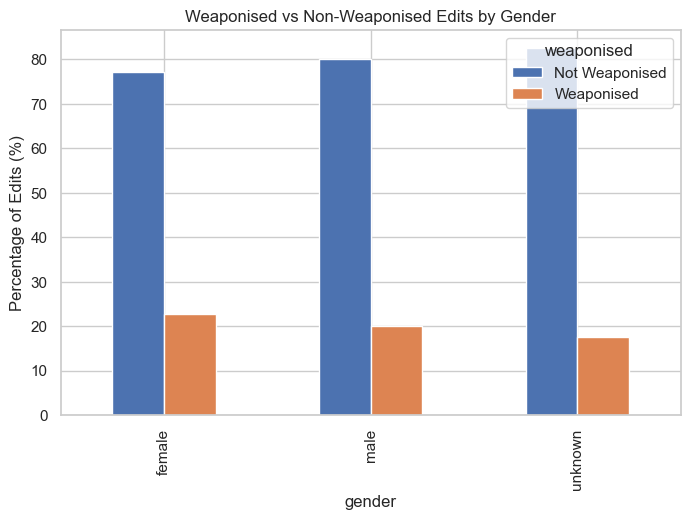

In [72]:
pd.crosstab(
    df_enriched['gender'],
    df_enriched['weaponised'],
    normalize='index'
).mul(100).plot.bar(
    figsize=(8,5),
    title="Weaponised vs Non-Weaponised Edits by Gender",
    ylabel="Percentage of Edits (%)"
)

## Block 

In [73]:
df_all_user_metadata_block = df_all_user_metadata.dropna(axis='index', how='any', subset=['blockid'])
df_all_user_metadata_block


,userid,user,editcount,registration,groups,emailable,gender,invalid,blockid,blockedby,blockedbyid,blockreason,blockedtimestamp,blockexpiry,blocknocreate,blockowntalk,blockedtimestampformatted,blockemail,blockpartial
29,21854733.0,Adûnâi,4023.0,2014-07-17T20:52:01Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,9991115.0,Ohnoitsjamie,507787.0,[[WP:No personal attacks|Personal attacks]] or...,2020-08-03T14:05:34Z,infinite,NaN,NaN,"14:05, 3 August 2020",NaN,NaN
52,37858148.0,Starzoner,143882.0,2019-11-18T02:53:02Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,10444906.0,Nick,319064.0,Abusing [[WP:Sock puppetry|multiple accounts]]...,2021-03-20T16:26:46Z,infinite,NaN,NaN,"16:26, 20 March 2021",NaN,NaN
54,38454508.0,Capewearer,11045.0,2020-02-02T20:53:10Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,10177207.0,TonyBallioni,5527268.0,{{checkuserblock-account}}: BKFIP,2020-11-13T20:43:32Z,infinite,NaN,NaN,"20:43, 13 November 2020",NaN,NaN
56,33788042.0,Love of Corey,54576.0,2018-05-17T20:51:33Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,19513375.0,Moneytrees,33316798.0,{{checkuserblock-account}}: See [[Wikipedia:So...,2023-04-30T03:00:33Z,infinite,NaN,NaN,"03:00, 30 April 2023",NaN,NaN
67,40853603.0,Haziq Nur Iman,115.0,2020-12-26T03:28:47Z,"['*', 'user', 'autoconfirmed', 'oathauth-twofa...",NaN,unknown,NaN,10329677.0,ToBeFree,16759563.0,Persistent addition of [[WP:INTREF|unsourced c...,2021-01-24T16:20:58Z,infinite,NaN,NaN,"16:20, 24 January 2021",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,83740.0,ThomasK,3221.0,2004-07-15T07:35:15Z,"['*', 'user', 'autoconfirmed']",NaN,unknown,NaN,1855633.0,DragonflySixtyseven,62058.0,"wait, sorry, wrong person",2010-03-24T17:46:26Z,infinite,NaN,NaN,"17:46, 24 March 2010",NaN,NaN
2300,330204.0,Molobo,13968.0,2005-07-12T14:30:15Z,"['*', 'user', 'autoconfirmed']",NaN,unknown,NaN,1612635.0,Future Perfect at Sunrise,1224855.0,"account possibly compromised, according to cla...",2009-10-16T14:12:48Z,infinite,NaN,NaN,"14:12, 16 October 2009",NaN,NaN
2309,10783848.0,Xbypass,2150.0,2009-10-15T09:23:46Z,"['extendedconfirmed', '*', 'user', 'autoconfir...",NaN,unknown,NaN,25152317.0,Moneytrees,33316798.0,[[WP:CV|Copyright violations]],2025-05-01T02:51:09Z,infinite,NaN,NaN,"02:51, 1 May 2025",NaN,NaN
2324,487310.0,Kintetsubuffalo,203496.0,2005-10-11T02:11:02Z,"['extendedconfirmed', 'reviewer', '*', 'user',...",NaN,male,NaN,19082704.0,Catfish Jim and the soapdish,5498498.0,Hell no.,2023-04-01T16:58:42Z,infinite,NaN,NaN,"16:58, 1 April 2023",NaN,NaN


<Axes: ylabel='count'>

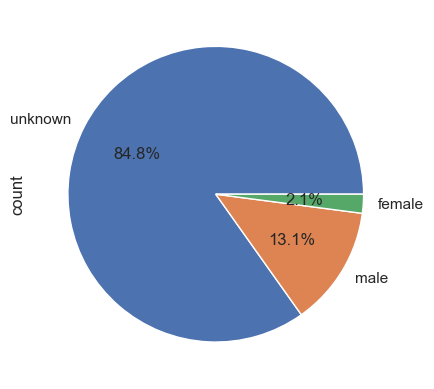

In [71]:
df_all_user_metadata_block['gender'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='Frequency'>

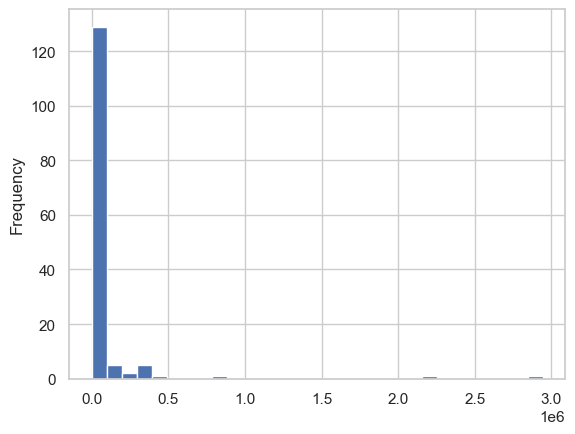

In [76]:
df_all_user_metadata_block['editcount'].plot.hist(bins=30)

In [81]:
# get a valid date format for the registration date
df_all_user_metadata_block['registration'] = pd.to_datetime(
    df_all_user_metadata_block['registration'],
    errors='coerce'
)

# get a valid date format for the block date
df_all_user_metadata_block['blockedtimestamp'] = pd.to_datetime(
    df_all_user_metadata_block['blockedtimestamp'],
    errors='coerce'
)

# compute the difference between the 2
df_all_user_metadata_block['days_to_block'] = (
    df_all_user_metadata_block['blockedtimestamp']
    - df_all_user_metadata_block['registration']
).dt.days

# ensure the values are valid
df_all_user_metadata_block = df_all_user_metadata_block[
    df_all_user_metadata_block['days_to_block'] >= 0
]

# 6.9 percent of users blocked within the 24 hours after their account creation date
(df_all_user_metadata_block['days_to_block'] <= 1).mean() * 100

6.896551724137931

<Axes: ylabel='Frequency'>

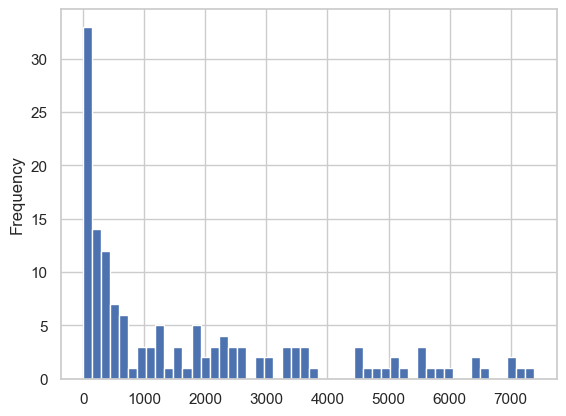

In [84]:
df_all_user_metadata_block['days_to_block'].plot.hist(bins=50)

<Axes: title={'center': 'Weaponised vs Non-Weaponised Edits by Block Status'}, xlabel='is_blocked', ylabel='Percentage of Edits (%)'>

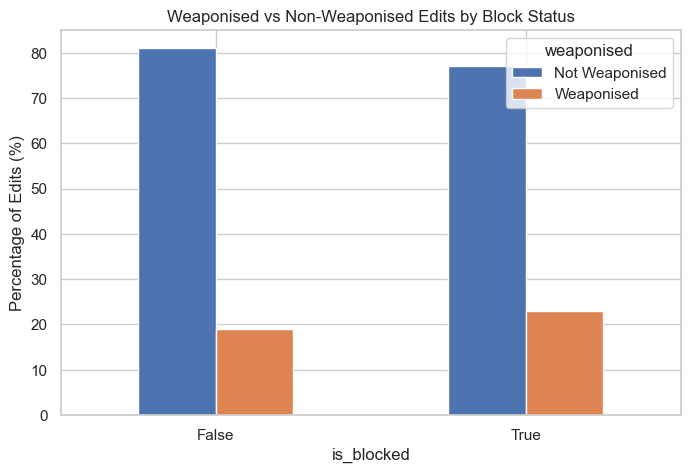

In [92]:
df_enriched['is_blocked'] = df_enriched['blockid'].notna()

pd.crosstab(
    df_enriched['is_blocked'],
    df_enriched['weaponised'],
    normalize='index'
).mul(100).plot.bar(
    figsize=(8,5),
    title="Weaponised vs Non-Weaponised Edits by Block Status",
    ylabel="Percentage of Edits (%)",
    rot=0
)

## Registration

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_59068/1582903133.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["user_type", "age_bin"])["weaponised_rate"]


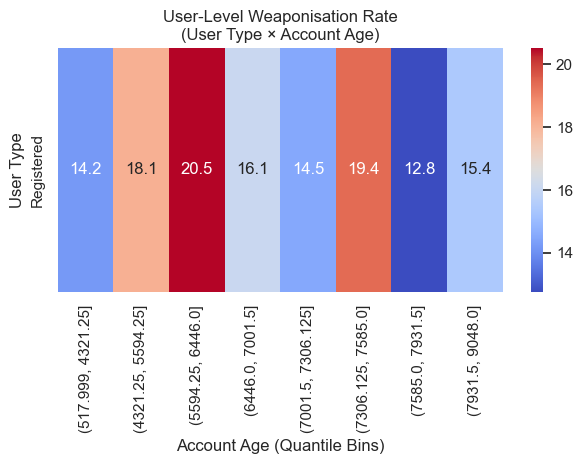

In [103]:
df_enriched_registration = compute_account_age(df_enriched)
df_enriched_registration = df_enriched_registration[df_enriched_registration['user_type'] == 'Registered']

df_enriched_registration["weaponised_binary"] = (
    df_enriched_registration["weaponised"]
    .eq("Weaponised")
    .astype(int)
)

user_level = (
    df_enriched_registration
    .groupby(["user", "user_type"])
    .agg(
        account_age_days=("account_age_days", "first"),
        weaponised_rate=("weaponised_binary", "mean")
    )
)

user_level["age_bin"] = pd.qcut(user_level["account_age_days"], q=8)

pivot_user = (
    user_level
    .groupby(["user_type", "age_bin"])["weaponised_rate"]
    .mean()
    .mul(100)
    .unstack()
)

sns.heatmap(pivot_user, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("User-Level Weaponisation Rate\n(User Type × Account Age)")
plt.ylabel("User Type")
plt.xlabel("Account Age (Quantile Bins)")
plt.tight_layout()
plt.show()


## Editcount

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_59068/548309439.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("editcount_bin")["weaponised_binary"]


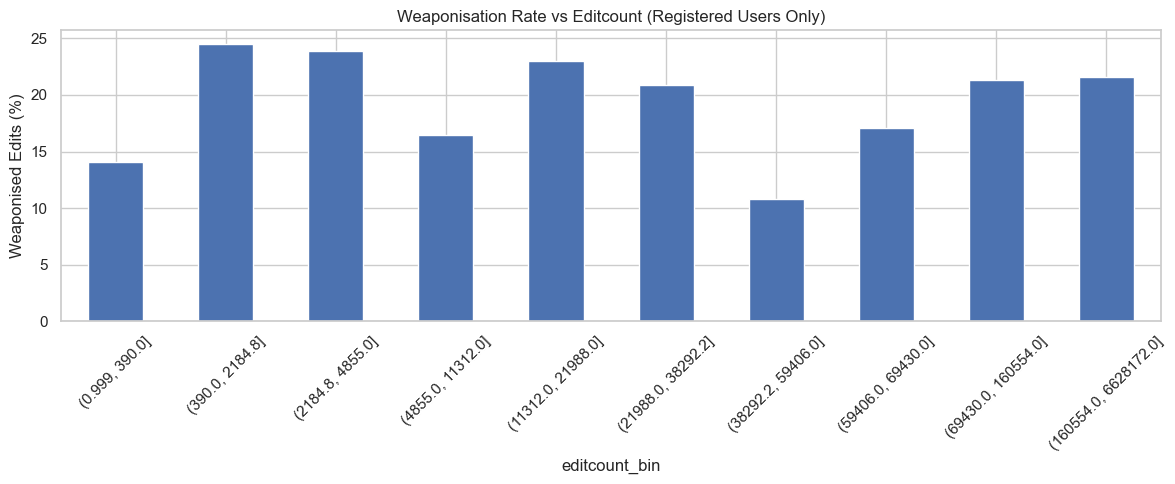

In [101]:
(
    df_enriched[df_enriched["user_type"] == "Registered"]
    .assign(
        weaponised_binary=lambda d: d["weaponised"].eq("Weaponised").astype(int),
        editcount_bin=lambda d: pd.qcut(d["editcount"], q=10, duplicates="drop")
    )
    .groupby("editcount_bin")["weaponised_binary"]
    .mean()
    .mul(100)
    .plot.bar(
        figsize=(12, 5),
        title="Weaponisation Rate vs Editcount (Registered Users Only)",
        ylabel="Weaponised Edits (%)",
        rot=45
    )
)
plt.tight_layout()
plt.show()


## Account age and editcount

/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_59068/905664244.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_bin", "editcount_bin"])["weaponised_binary"]


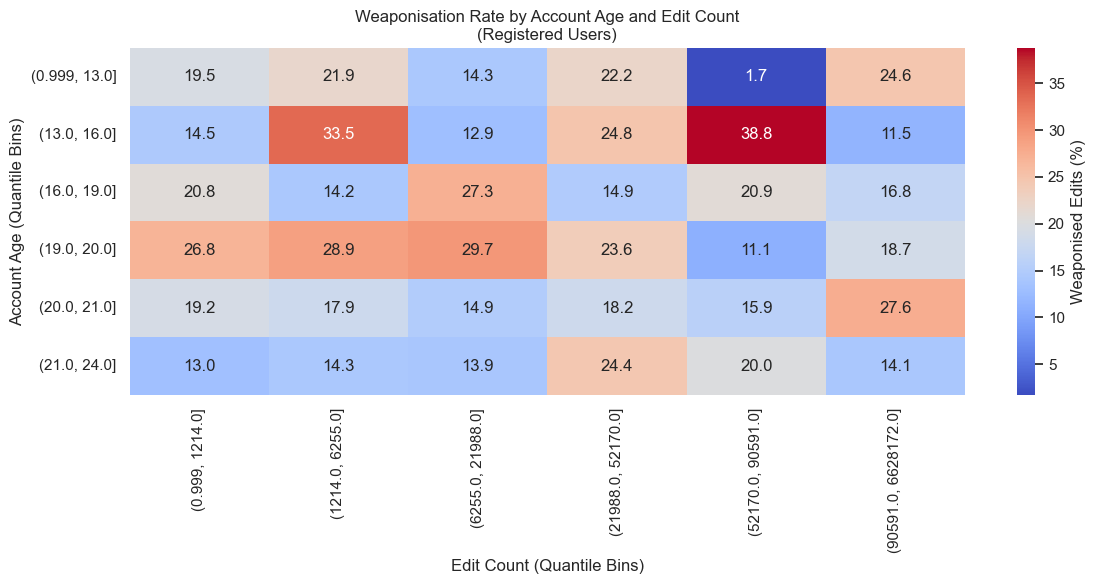

In [105]:
df_enriched_age = compute_account_age(df_enriched)

df_reg = df_enriched_age[df_enriched_age["user_type"] == "Registered"].copy()

df_reg["weaponised_binary"] = df_reg["weaponised"].eq("Weaponised").astype(int)

df_reg["account_age_years"] = df_reg["account_age_days"] // 365

df_reg["editcount_bin"] = pd.qcut(df_reg["editcount"], q=6, duplicates="drop")
df_reg["age_bin"] = pd.qcut(df_reg["account_age_years"], q=6, duplicates="drop")

pivot = (
    df_reg
    .groupby(["age_bin", "editcount_bin"])["weaponised_binary"]
    .mean()
    .mul(100)
    .unstack()
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Weaponised Edits (%)"}
)

plt.title("Weaponisation Rate by Account Age and Edit Count\n(Registered Users)")
plt.xlabel("Edit Count (Quantile Bins)")
plt.ylabel("Account Age (Quantile Bins)")
plt.tight_layout()
plt.show()


## Groups

In [113]:
import ast

def parse_groups(val):
    if pd.isna(val):
        return []
    try:
        # Ensure it's list-like
        return [g.strip() for g in ast.literal_eval(val)]
    except Exception:
        # Fallback if malformed
        return []

df_enriched["groups"] = df_enriched["groups"].apply(parse_groups)

all_groups = [
    g
    for groups in df_enriched["groups"]
    for g in groups
]

unique_groups = sorted(set(all_groups))

print(f"Number of unique rights: {len(unique_groups)}")
for g in unique_groups:
    print("-", g)

df_enriched["groups"] = df_enriched["groups"].apply(
    lambda g: [x for x in g if x != "*"]
)


Number of unique rights: 24
- *
- abusefilter
- abusefilter-helper
- accountcreator
- autoconfirmed
- autoreviewer
- bot
- bureaucrat
- checkuser
- eventcoordinator
- extendedconfirmed
- extendedmover
- filemover
- ipblock-exempt
- massmessage-sender
- oathauth-twofactorauth
- patroller
- reviewer
- rollbacker
- suppress
- sysop
- templateeditor
- temporary-account-viewer
- user


In [114]:
df_groups = df_enriched.explode("groups")
df_groups = df_groups[df_groups["groups"] != ""]

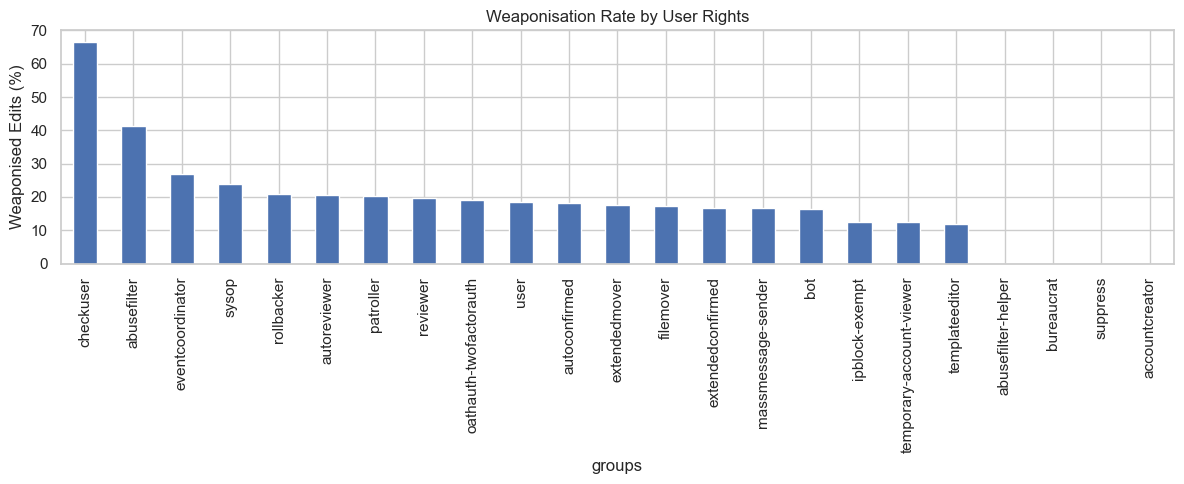

In [115]:
(
    df_groups
    .groupby("groups")["weaponised"]
    .apply(lambda s: (s == "Weaponised").mean() * 100)
    .sort_values(ascending=False)
    .plot.bar(figsize=(12,5))
)
plt.ylabel("Weaponised Edits (%)")
plt.title("Weaponisation Rate by User Rights")
plt.tight_layout()
plt.show()


## User Rights Log

We try to web scrap a web site that keeps the log of the user rights chnged over time. Having access to this data will allow us to know what was the rights of a certain user at a certain moment when a edit from him was made in a certain time. This leads us to go from a static analysis to a dynamic-time dependant- analysis

In [1]:
import requests
from bs4 import BeautifulSoup

URL_TEMPLATE = "https://xtools.wmcloud.org/ec-rightschanges/en.wikipedia.org/{username}"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def scrape_xtools_rights_changes(username):
    url = URL_TEMPLATE.format(username=username)
    response = requests.get(url, headers=HEADERS)

    if response.status_code != 200:
        return {"user": username, "error": f"HTTP {response.status_code}"}

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the rights changes table
    table = soup.find("table", class_=lambda c: c and "rightschanges-table" in c)
    if not table:
        return {"user": username, "error": "No table found (user may have no rights changes)"}

    rows = table.find("tbody").find_all("tr")

    changes = []
    for row in rows:
        cols = [c.get_text(strip=True) for c in row.find_all("td")]
        
        if len(cols) != 4:
            continue
            
        change = {
            "timestamp": cols[0],
            "rights": cols[1],
            "performer": cols[2],
            "summary": cols[3],
        }
        changes.append(change)

    return {
        "user": username,
        "rights_changes": changes
    }

def build_dataframe_from_groups_change(username):
    data = scrape_xtools_rights_changes(username)

    # If no rights_changes key, return an empty dataframe with correct columns
    if "rights_changes" not in data:
        print('lol')
        return pd.DataFrame(columns=["timestamp", "rights", "performer", "summary", "user"])

    df_data = pd.DataFrame(data["rights_changes"])
    df_data["user"] = data["user"]
    return df_data

def run_rights_change_scraping_one_batch(sublists, batch_idx=0):
    """
    Processes exactly ONE sublist (batch) and then stops.
    batch_idx: index of the sublist to process (0-based)
    """
    df_list = []

    batch = sublists[batch_idx]
    print(f"Processing batch {batch_idx + 1}/{len(sublists)}")

    for user in batch:
        df_metadata = build_dataframe_from_groups_change(user)
        print(df_metadata.shape)
        df_list.append(df_metadata)

    if not df_list:
        return pd.DataFrame()

    df_batch = pd.concat(df_list, ignore_index=True)
    print("Batch completed. Stopping execution.")
    return df_batch